#Izikevich model

[TP2 Redes Neuronales](https://github.com/jipphysics/redes-neuronales-2023/blob/main/tp2-2023.pdf)

[Guia 9 - Izhikevich](https://colab.research.google.com/drive/1aEqZLJMZ1cPU7Ll9SLhIE0mt2g9MZWNL?usp=drive_link)

##Library

In [ ]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

##Runge Kutta (4°) integrator

In [ ]:
# Importo librerías y defino funciones para la ODE
import numpy as np
from collections.abc import Iterable

def euler(f,x,t,dt,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        dt = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+dt) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+dt*f(x,t,p)

def rk4(f,x,t,dt,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        dt = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+dt) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*dt*k1,t+0.5*dt,p)
    k3 = f(x+0.5*dt*k2,t+0.5*dt,p)
    k4 = f(x+dt*k3,t+dt,p)
    return x+dt*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(f,xa,a,b,k,p,m=rk4,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0

    if issubclass(type(xa), Iterable): n = len(xa) # si solo paso un punto como CI no hace falta q lo mande en una lista
    else: n = 1          # Dimensión del problema

    dt = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.arange(a, k+1)*dt
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        w[:,j+1] = m(f,w[:,j],t[j],dt,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w


## Model



The Izhikevich model (ref. 1.) is a simplification of the well-known model introduced by Hodgkin and Huxley in 1952 (ref. 2., Nobel Prize in Physiology and Medicine in 1963) to describe the firing behavior of a neuron's membrane potential.

The Izhikevich model is described in terms of the following first-order, two-dimensional Ordinary Differential Equation (ODE)

\begin{eqnarray}
v'(t) &=& gv^2(t) + qv(t) + w - u(t) + I(t) \\
u'(t) &=& a(bv(t)-u(t))
\end{eqnarray}

accompanied by the following *reset* condition


\begin{eqnarray}
v(t) &\leftarrow& c \\
u(t) &\leftarrow& u(t) + d \\
\end{eqnarray}

which is imposed when the condition $v(t)\geq s$ is fulfilled.



In all this equations, $a$, $b$, $c$, $d$, $g$, $q$, $w$ y $s$ are paremeters of the model.
Also, we consider a time-dependent function, $I:\mathbb{R}\ni t\to I(t)\in \mathbb{R}$, that represents an auxiliary (may be extern) current.


Bibliography:

1. Eugene M. Izhikevich, Simple Model of Spiking Neurons, IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 14, NO. 6, P. 1569, NOVEMBER 2003
2. https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model


##Solution

In [ ]:
def I(t):
  V = 10
  t_thresh = 25
  if t>=t_thresh:
    return V
  else:
    return 0

# Armo la funcion de las derivadas de v y u
def izhikevich(arr, t, p): #p
  """
    Calcula las derivadas de v y u

    Argumentos de entrada:

        arr = array con valores [v,u]
        I : Valor de la corriente en ese instante
        p = parametros : [g,q,w,a,b,c,d,s,I]

    Retorna:

        [v', u']
  """
  g,q,w,a,b,c,d,s, I = p
  v, u = arr

  v_ = g*v**2 + q*v + w - u + I(t)
  u_ = a * (b*v - u)

  return np.array([v_, u_])

def reset(arr, t, p):
  """
    Chequeo si v >= s, en ese caso aplico
        v(t) ← c
        u(t) ← u(t)+d
    si no se supera s devuelvo [v,u] tal como llegó

    Argumentos de entrada:

        arr = array con valores [v,u]
        p = parametros : [g,q,w,a,b,c,d,s]

    Retorna:
        [v, u]
    """

  g,q,w,a,b,c,d,s = p[:-1]
  v, u = arr
  if v >= s:
    return np.array([c, u+d])
  else:
    return arr

## Kind of shoots


In [ ]:
g=0.04
q=5
w=140
a=0.02
b=0.2
c=-65
d=8
s=30

p = [g,q,w,a,b,c,d,s, I]

v0 = -70
u0 = b * v0

a = 0
b = 200
h = 0.1
k = (b-a)/h

ts, [vs, us] = integrador_ode(izhikevich, [v0, u0], 0, 200, int(k), p, c = reset)


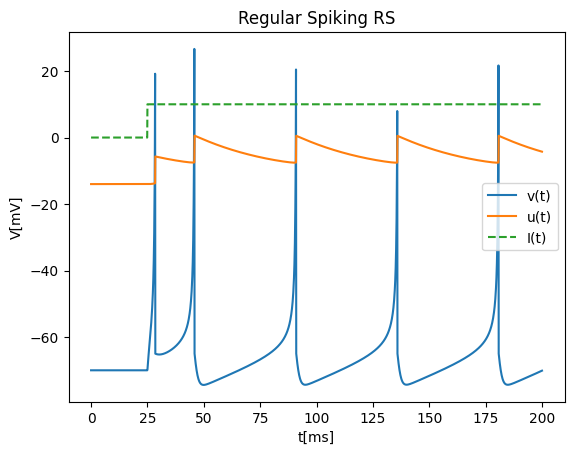

In [ ]:
plt.plot(ts,vs,label='v(t)')
plt.xlabel('t[ms]')
plt.ylabel('V[mV]')
plt.plot(ts,us,label='u(t)')
plt.plot(ts,np.vectorize(I)(ts),label='I(t)',linestyle='--')
plt.title('Regular Spiking RS')
plt.legend()

$$
\begin{aligned}
& \text {Tabla 1. Parmaterización por caso. }\\
&\begin{array}{ccccc}
\hline \hline
\text { Caso } & a & b & c & d & I \\
\hline
\text { RS }  & 0.02 & 0.2  & -65 & 8    & I_1 \\
\text { IB }  & 0.02 & 0.2  & -55 & 4    & I_1 \\
\text { CH }  & 0.02 & 0.2  & -50 & 2    & I_1 \\
\text { FS }  & 0.1  & 0.2  & -65 & 2    & I_1 \\
\text { TC1 } & 0.02 & 0.25 & -65 & 0.05 & I_2 \\
\text { TC2 } & 0.02 & 0.25 & -65 & 0.05 & I_3 \\
\text { RZ }  & 0.1  & 0.25 & -65 & 2    & I_4 \\
\text { LTS } & 0.02 & 0.25 & -65 & 2    & I_1 \\
\hline
\end{array}
\end{aligned}
$$

donde

\begin{eqnarray}
I_1(t)
&=&
\left\{
\begin{array}{ll}
0  & t < 25 \\
10 & c.c.
\end{array}
\right. \\
I_2(t)
&=&
\left\{
\begin{array}{ll}
0  & t < 150 \\
2.5 & c.c.
\end{array}
\right. \\
I_3(t)
&=&
\left\{
\begin{array}{ll}
-15  & t < 100 \\
0 & c.c.
\end{array}
\right. \\
I_4(t)
&=&
\left\{
\begin{array}{ll}
0    & t < 10 \\
.165 & 10 \leq t < 100 \\
10   & 100 \leq t < 105 \\
.165 & c.c.
\end{array}
\right.
\end{eqnarray}

Escribo los parámetros en un DataFrame

In [ ]:
parametros = pd.DataFrame({
    'a': [0.02, 0.02, 0.02, 0.1, 0.02, 0.02, 0.1, 0.02],
    'b': [0.2, 0.2, 0.2, 0.2, 0.25, 0.25, 0.26, 0.25],
    'c': -1*np.array([65, 55,50,65,65,65,65,65 ]),
    'd': [8,4,2,2,0.05,0.05,2,2],
    'I': [1,1,1,1,2,3,4,1] })
titulos = [ 'Regular spiking (RS)', 'Intrinsically bursting (IB)',  'CH',  'FS',  'TC1' , 'TC2' , 'RZ' , 'LTS']

titulos = [ 'Regular spiking (RS)', 'Intrinsically bursting (IB)',  'Chattering (CH)',  'Fast spiking (FS)',  'Thalamo-cortical (TC1)' , 'Thalamo-cortical (TC2)' , 'Resonator (RZ)' , 'Low-threshold spiking (LTS)']

v0s = [-70, -70, -70 ,-70 , -64.5, -84.5, -62.5, -64.35]
parametros

,a,b,c,d,I
0,0.02,0.20,-65,8.00,1
1,0.02,0.20,-55,4.00,1
2,0.02,0.20,-50,2.00,1
3,0.10,0.20,-65,2.00,1
4,0.02,0.25,-65,0.05,2
5,0.02,0.25,-65,0.05,3
6,0.10,0.26,-65,2.00,4
7,0.02,0.25,-65,2.00,1


In [ ]:
def I1(t):
  V = 10
  t_thresh = 25
  if t>t_thresh:
    return V
  else:
    return 0

def I2(t):
  V = 2.5
  t_thresh = 50
  if t>t_thresh:
    return V
  else:
    return 0

def I3(t):
  if t>50:
    return 0
  else:
    return -15

def I4(t):
  if t>=105:
    return .165
  if t>=100:
    return 10
  if t>=10:
    return .165
  if t<10:
    return 0

def I4(t):
  if t<10:
    return 0
  elif t>=10 and t<100:
    return 0.2
  elif t>=100 and t<105:
    return 2.5
  else:
    return 0.2


Is = [I1, I2, I3, I4]

Grafico las corrientes a ver si son correctas

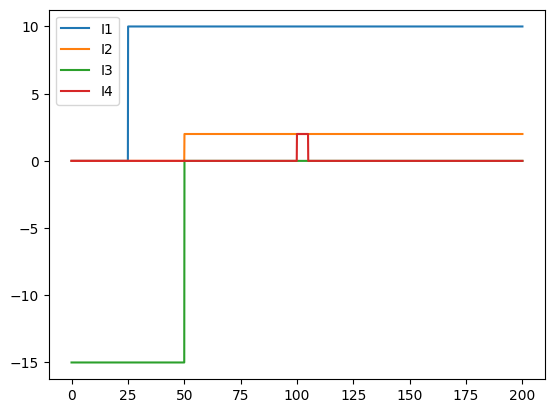

In [ ]:
for i,I in enumerate(Is):
  plt.plot(ts, np.vectorize(I)(ts), label = f'I{i+1}')
plt.legend()

<ipython-input-10-e89d82fb9ba3>:43: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p2, = twin1.plot(ts,np.vectorize(I)(ts), 'g-',label='I(t)',linestyle='-')


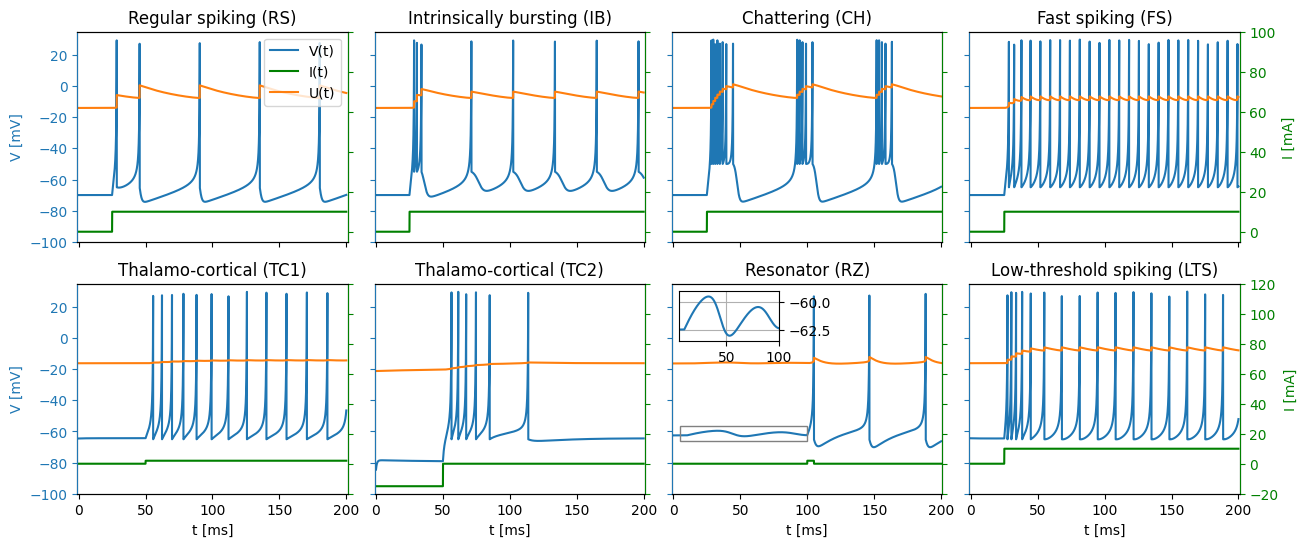

In [ ]:
fig, axs = plt.subplots(2, 4, figsize = (15,6) , sharex=True, sharey=True)
xlim = (-1,201)
ylim = (-100,35)


for i, titulo in enumerate(titulos):
  a, b, c , d, i_I = parametros.iloc[i]
  I = Is[int(i_I-1)]


  p = [g,q,w,a,b,c,d,s, I]

  v0 = v0s[i]
  u0 = b * v0

  a = 0
  b = 200
  h = 0.01
  k = (b-a)/h

  ts, [vs, us] = integrador_ode(izhikevich, [v0, u0], 0, 200, int(k), p, c = reset)

  row = (i) // 4
  col = i % 4
  ax = axs[row, col]
  # print(f'{row}, {col}')

  # ax.plot(ts,us,label='u(t)')
  # ax.plot(ts,np.vectorize(I)(ts),label='I(t)',linestyle='-')
  ax.set_title(titulo)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  p1, = ax.plot(ts,vs , label='V(t)')
  p3, = ax.plot(ts,us , label='U(t)')
  ax.tick_params(axis='y', colors=p1.get_color())

  ax.yaxis.label.set_color(p1.get_color())


  twin1 = ax.twinx()
  p2, = twin1.plot(ts,np.vectorize(I)(ts), 'g-',label='I(t)',linestyle='-')
  twin1.set_ylim(-20, 120)
  twin1.tick_params(axis='y', colors=p2.get_color())
  twin1.spines['right'].set_color(p2.get_color())
  twin1.tick_params( labelright = False)
  twin1.spines['left'].set_color(p1.get_color())
  # twin1.tick_params( labelright = True)
  # twin1.yaxis.label.set_color(p2.get_color())
  # twin1.tick_params(axis='y', colors=p2.get_color())

  if col == 3:
    twin1.tick_params( labelright = True)
    twin1.yaxis.label.set_color(p2.get_color())
    twin1.tick_params(axis='y', colors=p2.get_color())
    twin1.set_ylabel('I [mA]')

  if col == 0:
    ax.set_ylabel('V [mV]')
    if row == 0:
      ax.legend()
      ax.legend(handles = [p1,p2,p3], loc = 'upper right')
      # twin1.legend()

  if row == 1:
    ax.set_xlabel('t [ms]')
    twin1.set_ylim(-20, 120)

  else:
    twin1.set_ylim(-5, 100)

  if i == 6:
    x1, x2, y1, y2 = 5, 100, -63.5, -59

    # Crear un gráfico secundario (zoomed_inset_axes)
    axins = inset_axes(ax, loc = 'upper left',height = .5, width = 1)# bbox_to_anchor = [500,200,1,10])
    # axins.set_position([5, 100000, 0.1, 1])  # [left, bottom, width, height]

    axins.plot(ts, vs)
    axins.plot(ts,np.vectorize(I)(ts),label='I(t)',linestyle='-')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    # Agregar una caja con la región ampliada

    ax.indicate_inset([x1,y1-2.5, x2-x1, y2-y1+5],axins, alpha = 1)
    axins.yaxis.tick_right()
    axins.grid()

plt.subplots_adjust(wspace=0.1)

# axs[1,0].legend()
# for ax in fig.get_axes():
#     ax.label_outer()
plt.savefig('Tipos de neurona.pdf')


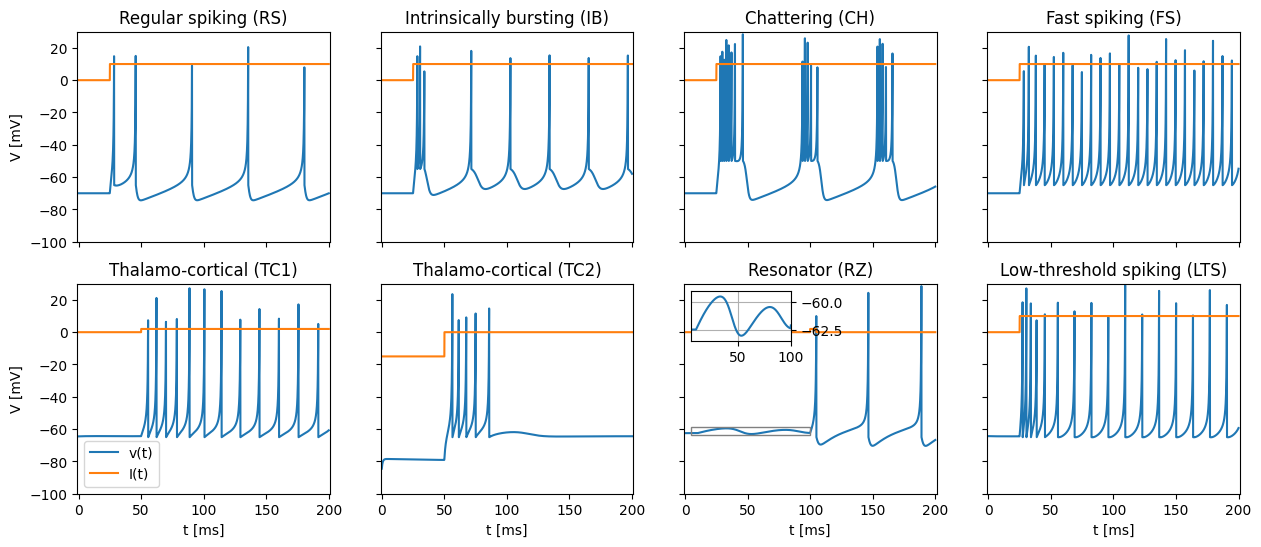

In [ ]:
fig, axs = plt.subplots(2, 4, figsize = (15,6) , sharex=True, sharey=True)
xlim = (-1,201)
ylim = (-100,30)


for i, titulo in enumerate(titulos):
  a, b, c , d, i_I = parametros.iloc[i]
  I = Is[int(i_I-1)]


  p = [g,q,w,a,b,c,d,s, I]

  v0 = v0s[i]
  u0 = b * v0

  a = 0
  b = 200
  h = 0.1
  k = (b-a)/h

  ts, [vs, us] = integrador_ode(izhikevich, [v0, u0], 0, 200, int(k), p, c = reset)

  row = (i) // 4
  col = i % 4
  ax = axs[row, col]
  # print(f'{row}, {col}')
  ax.plot(ts,vs,label='v(t)')
  if row == 1:
    ax.set_xlabel('t [ms]')
  if col == 0:
    ax.set_ylabel('V [mV]')
  # ax.plot(ts,us,label='u(t)')
  ax.plot(ts,np.vectorize(I)(ts),label='I(t)',linestyle='-')
  ax.set_title(titulo)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  if i == 6:
    x1, x2, y1, y2 = 5, 100, -63.5, -59

    # Crear un gráfico secundario (zoomed_inset_axes)
    axins = inset_axes(ax, loc = 2,height = .5, width = 1)# bbox_to_anchor = [500,200,1,10])
    # axins.set_position([5, 100000, 0.1, 1])  # [left, bottom, width, height]

    axins.plot(ts, vs)
    axins.plot(ts,np.vectorize(I)(ts),label='I(t)',linestyle='-')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    # Agregar una caja con la región ampliada

    ax.indicate_inset([x1,y1, x2-x1, y2-y1],axins, alpha = 1)
    axins.yaxis.tick_right()
    axins.grid()


axs[1,0].legend()
# for ax in fig.get_axes():
#     ax.label_outer()


## Making a sincronized neural network of 1000 neurons

Pruebo para N=1000

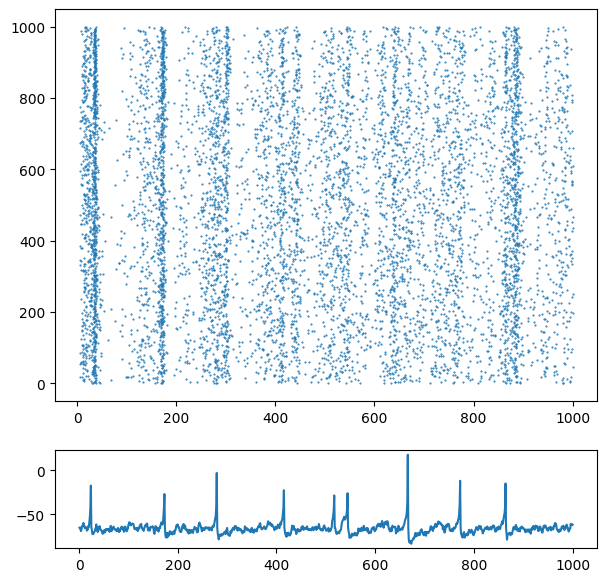

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
v_indiv = []
m = 1
# Excitatory neurons Inhibitory neurons
Ne = int(800 * m)
Ni = int(200 * m)
n= Ne + Ni

neurona = np.random.randint(0, Ne + Ni -1)

re = np.random.rand(Ne)
ri = np.random.rand(Ni)
a = np.concatenate((0.02 * np.ones(Ne), 0.02 + 0.08 * ri))
b = np.concatenate((0.2 * np.ones(Ne), 0.25 - 0.05 * ri))
c = np.concatenate((-65 + 15 * re**2, -65 * np.ones(Ni)))
d = np.concatenate((8 - 6 * re**2, 2 * np.ones(Ni)))

S = np.hstack((0.5 * np.random.rand(Ne + Ni, Ne), -np.random.rand(Ne + Ni, Ni)))

# S=np.random.random(size=(n,n))
# S[:,:Ne]*=0.5 #peso de las exitatorias
# S[:,Ne:]*=-1 #peso de las inhibitorias

v = -65 * np.ones(Ne + Ni)  # Initial values of v
u = b * v  # Initial values of u

firings = []  # spike timings

for t in range(1, 1001):  # simulation of 1000 ms
    I = np.concatenate((5 * np.random.randn(Ne), 2 * np.random.randn(Ni)))  # thalamic input
    fired = np.where(v >= 30)[0]  # indices of spikes

    firings.extend(list(zip(t + np.zeros(len(fired)), fired)))
    v[fired] = c[fired]
    u[fired] += d[fired]
    v_indiv.append(v[neurona])
    I += np.sum(S[:, fired], axis=1)
    v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)  # step 0.5 ms
    # v_indiv.append(v[neurona])
    v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)  # for numerical stability
    u += a * (b * v - u)


firings = np.array(firings)

fig, axs = plt.subplots(2, 1, height_ratios= [4, 1],  figsize = (7,7))
ax1, ax2 = axs
ax1.plot(firings[:, 0], firings[:, 1],'.',markersize=1)
ax2.plot(np.arange(1,1001), v_indiv)
# ax2.set_ylim(min(v_indiv), max(v_indiv)*1.2)
plt.show()

Calculate the period of the shoots

In [ ]:
tiempos_disparo = [[] for x in range(1000)]
for fire in firings:
  tiempos_disparo[int(fire[1])].append(fire[0])
promedios = []
for neurona in tiempos_disparo:
  promedios.append(np.mean(np.diff(np.array(neurona))))
x = np.array(promedios)
periodo = np.mean(x[~np.isnan(x)])
frecuencia_disp = 1/ (periodo/1000)

7.1152099950559275


To obtain this value with an associated statistical error, let's simulate this network 1000 times and for each simulation, calculate the average firing frequency.

With these 1000 values, we'll calculate their mean and standard deviation.

In [ ]:
# Trato de conseguir un valor con error para la frecuencia de disparo
iteraciones = 1000

arr_frec_prom = np.zeros(iteraciones)

for j in range(iteraciones):
  v_indiv = []
  m = 1
  # Excitatory neurons Inhibitory neurons
  Ne = int(800 * m)
  Ni = int(200 * m)
  n= Ne + Ni

  neurona = np.random.randint(0, Ne + Ni -1)

  re = np.random.rand(Ne)
  ri = np.random.rand(Ni)
  a = np.concatenate((0.02 * np.ones(Ne), 0.02 + 0.08 * ri))
  b = np.concatenate((0.2 * np.ones(Ne), 0.25 - 0.05 * ri))
  c = np.concatenate((-65 + 15 * re**2, -65 * np.ones(Ni)))
  d = np.concatenate((8 - 6 * re**2, 2 * np.ones(Ni)))

  S = np.hstack((0.5 * np.random.rand(Ne + Ni, Ne), -np.random.rand(Ne + Ni, Ni)))

  # S=np.random.random(size=(n,n))
  # S[:,:Ne]*=0.5 #peso de las exitatorias
  # S[:,Ne:]*=-1 #peso de las inhibitorias

  v = -65 * np.ones(Ne + Ni)  # Initial values of v
  u = b * v  # Initial values of u

  firings = []  # spike timings

  for t in range(1, 1001):  # simulation of 1000 ms
      I = np.concatenate((5 * np.random.randn(Ne), 2 * np.random.randn(Ni)))  # thalamic input
      fired = np.where(v >= 30)[0]  # indices of spikes

      firings.extend(list(zip(t + np.zeros(len(fired)), fired)))
      v[fired] = c[fired]
      u[fired] += d[fired]
      v_indiv.append(v[neurona])
      I += np.sum(S[:, fired], axis=1)
      v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)  # step 0.5 ms
      # v_indiv.append(v[neurona])
      v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)  # for numerical stability
      u += a * (b * v - u)

  firings = np.array(firings)

  tiempos_disparo = [[] for x in range(1000)]
  for fire in firings:
    tiempos_disparo[int(fire[1])].append(fire[0])
  promedios = []
  for neurona in tiempos_disparo:
    promedios.append(np.mean(np.diff(np.array(neurona))))
  x = np.array(promedios)
  periodo = np.mean(x[~np.isnan(x)])
  frecuencia_disp = 1/ (periodo/1000)


  arr_frec_prom[j] = frecuencia_disp

frec_prom = np.mean(arr_frec_prom)
frec_std = np.std(arr_frec_prom, ddof = 1)

print(f'La frecuencia de disparo promedio es de ({frec_prom} +- {frec_std / np.sqrt(iteraciones)})Hz')


La frecuencia de disparo promedio es de (7.046833920515061 +- 0.005429367247789351)Hz


Now let's test what happens when we increase the number of neurons in the network. Let's use
N=1000,1500,3000.

0
1
2


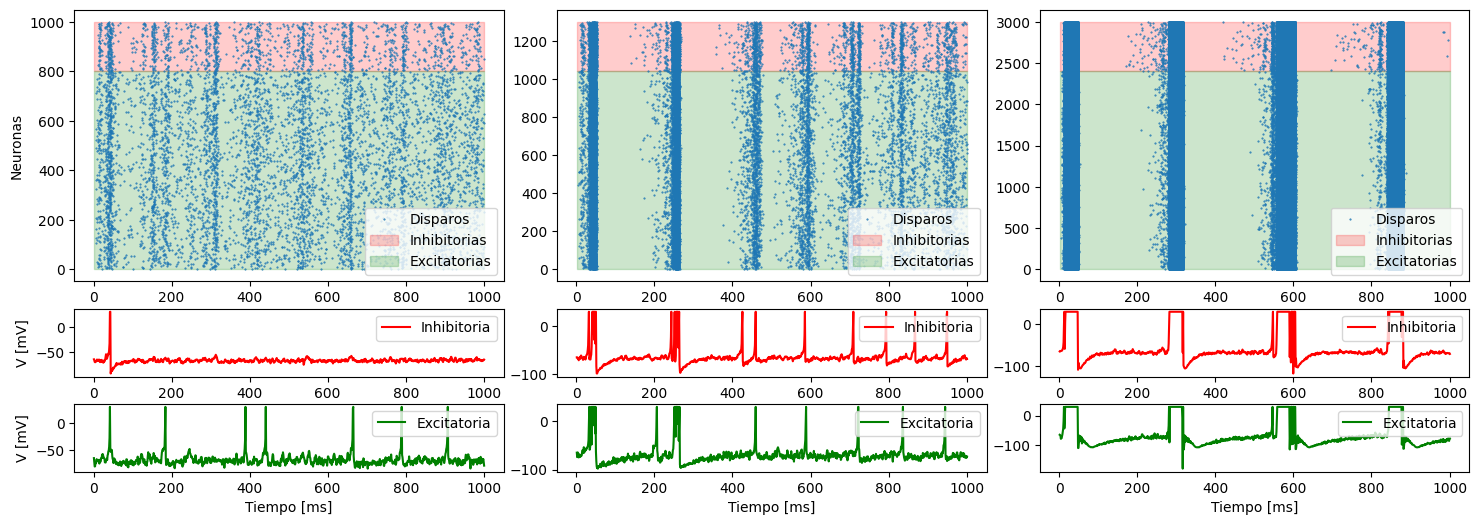

In [ ]:
from matplotlib.font_manager import MSFontDirectories
import numpy as np
import matplotlib.pyplot as plt

vs_indiv_i = []
vs_indiv_e = []

firings_list = []

ms = [1,1.3,3]

fig, axes = plt.subplots(3, len(ms), height_ratios= [4, 1,1],  figsize = (6 * len(ms),6))

for k, m in enumerate(ms):

  v_indiv_i = []
  v_indiv_e = []
  print(k)
  axs = axes[:,k]
  dt = 0.5
  t_tot = 1000 #1000ms
  iteraciones = int(t_tot / (dt*2))

  # Excitatory neurons Inhibitory neurons
  Ne = int(800 * m)
  Ni = int(200 * m)
  n= Ne + Ni

  neurona_e = np.random.randint(0, Ne -1)
  neurona_i = np.random.randint(Ne-1, Ne + Ni -1)

  re = np.random.rand(Ne)
  ri = np.random.rand(Ni)
  a = np.concatenate((0.02 * np.ones(Ne), 0.02 + 0.08 * ri))
  b = np.concatenate((0.2 * np.ones(Ne), 0.25 - 0.05 * ri))
  c = np.concatenate((-65 + 15 * re**2, -65 * np.ones(Ni)))
  d = np.concatenate((8 - 6 * re**2, 2 * np.ones(Ni)))

  S = np.hstack((0.5 * np.random.rand(Ne + Ni, Ne), -np.random.rand(Ne + Ni, Ni)))

  # S=np.random.random(size=(n,n))
  # S[:,:Ne]*=0.5 #peso de las exitatorias
  # S[:,Ne:]*=-1 #peso de las inhibitorias

  v = -65 * np.ones(Ne + Ni)  # Initial values of v
  u = b * v  # Initial values of u

  firings = []  # spike timings

  for t in range(1, iteraciones+1):  # simulation of 1000 ms
      I = np.concatenate((5 * np.random.randn(Ne), 2 * np.random.randn(Ni)))  # thalamic input
      fired = np.where(v >= 30)[0]  # indices of spikes

      firings.extend(list(zip(t + np.zeros(len(fired)), fired)))
      v[fired] = 30
      v_indiv_e.append(v[neurona_e])
      v_indiv_i.append(v[neurona_i])
      v[fired] = c[fired]
      u[fired] += d[fired]

      I += np.sum(S[:, fired], axis=1)
      v += dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # step 0.5 ms
      # v_indiv.append(v[neurona])
      # u += a * (b * v - u)
      v += dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # for numerical stability
      u += a * (b * v - u)

  firings = np.array(firings)
  firings_list.append(firings)


  ax1, ax2, ax3 = axs
  ax1.plot(firings[:, 0], firings[:, 1],'.',markersize=1, label = 'Disparos',  alpha = 1)
  if k==0:
    ax1.set_ylabel('Neuronas')
    ax2.set_ylabel('V [mV]')
    ax3.set_ylabel('V [mV]')
    # Calculo el periodo promedio de disparo



  x = np.linspace(1,t_tot + 1, iteraciones *1)
  ax3.plot(x, v_indiv_e, label = 'Excitatoria', color='g')
  ax3.set_xlabel(f'Tiempo [ms]')
  ax2.plot(x, v_indiv_i, label = 'Inhibitoria', color='r')

  x = np.linspace(1,t_tot + 1,100)
  unos = np.ones_like(x)

  ax1.fill_between(x, y1 =unos * Ne, y2=unos *(Ne+Ni), color='r',label = 'Inhibitorias', alpha = 0.2)
  ax1.fill_between(x,y1 =unos * 0, y2=unos *Ne, color='g',label = 'Excitatorias', alpha = 0.2)

  # ax2.set_ylim(min(v_indiv), max(v_indiv)*1.2)
  for j,i in enumerate(axs):
    if j!=0:
      i.legend(loc = 'upper right')
    else: i.legend(loc = 'lower right')




plt.subplots_adjust(wspace=0.125)

In [ ]:
plt.savefig('Red neuronal3.pdf')

**2)** Adjust the previous code to the mentioned theory by replacing the Heaviside step function
Θ
with the function.

$$
z(v)=\frac{87+v}{450}-0.0193
$$

In [ ]:
def z(v):
  return (87+v)/450-0.0193

0
1
2


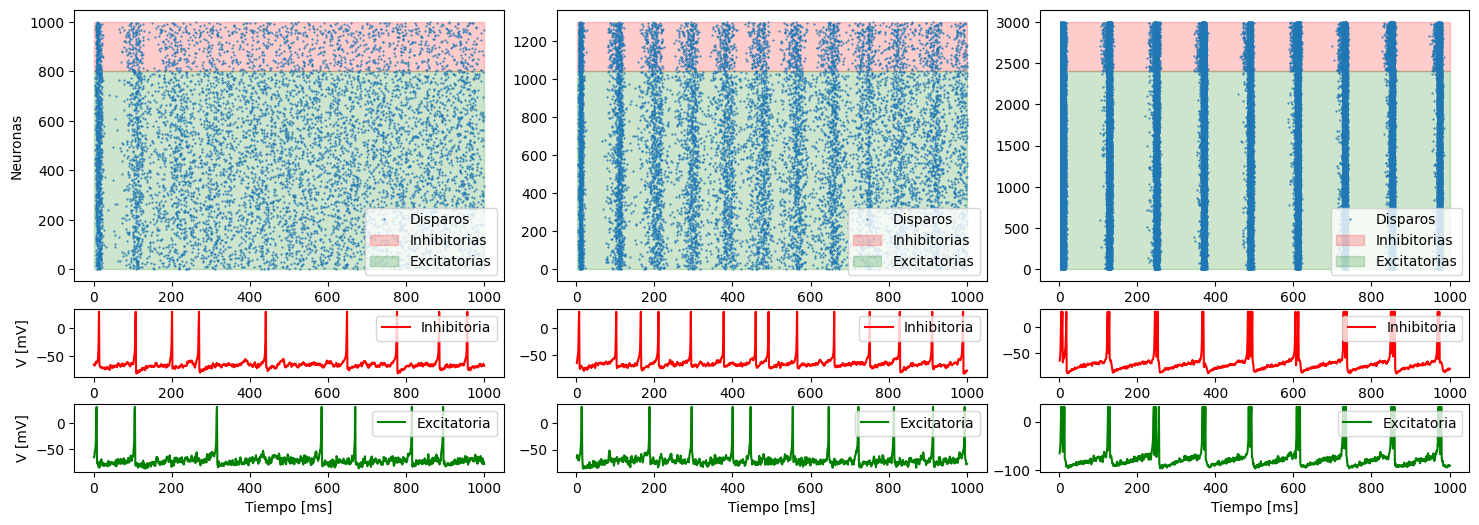

In [ ]:
from matplotlib.font_manager import MSFontDirectories
import numpy as np
import matplotlib.pyplot as plt

vs_indiv_i = []
vs_indiv_e = []

firings_list = []

ms = [1,1.3,3]

fig, axes = plt.subplots(3, len(ms), height_ratios= [4, 1,1],  figsize = (6 * len(ms),6))

for k, m in enumerate(ms):

  v_indiv_i = []
  v_indiv_e = []
  print(k)
  axs = axes[:,k]
  dt = 0.5
  t_tot = 1000 #1000ms
  iteraciones = int(t_tot / (dt*2))

  # Excitatory neurons Inhibitory neurons
  Ne = int(800 * m)
  Ni = int(200 * m)
  n= Ne + Ni

  neurona_e = np.random.randint(0, Ne -1)
  neurona_i = np.random.randint(Ne-1, Ne + Ni -1)

  re = np.random.rand(Ne)
  ri = np.random.rand(Ni)
  a = np.concatenate((0.02 * np.ones(Ne), 0.02 + 0.08 * ri))
  b = np.concatenate((0.2 * np.ones(Ne), 0.25 - 0.05 * ri))
  c = np.concatenate((-65 + 15 * re**2, -65 * np.ones(Ni)))
  d = np.concatenate((8 - 6 * re**2, 2 * np.ones(Ni)))

  S = np.hstack((0.5 * np.random.rand(Ne + Ni, Ne), -np.random.rand(Ne + Ni, Ni)))

  # S=np.random.random(size=(n,n))
  # S[:,:Ne]*=0.5 #peso de las exitatorias
  # S[:,Ne:]*=-1 #peso de las inhibitorias

  v = -65 * np.ones(Ne + Ni)  # Initial values of v
  u = b * v  # Initial values of u

  firings = []  # spike timings

  for t in range(1, iteraciones+1):  # simulation of 1000 ms
      I = np.concatenate((5 * np.random.randn(Ne), 2 * np.random.randn(Ni)))  # thalamic input
      fired = np.where(v >= 30)[0]  # indices of spikes

      firings.extend(list(zip(t + np.zeros(len(fired)), fired)))
      v[fired] = 30
      v_indiv_e.append(v[neurona_e])
      v_indiv_i.append(v[neurona_i])
      v[fired] = c[fired]
      u[fired] += d[fired]

      I += np.sum(S[:]*np.vectorize(z)(v), axis=1)
      v += dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # step 0.5 ms
      # v_indiv.append(v[neurona])
      # u += a * (b * v - u)
      v += dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # for numerical stability
      u += a * (b * v - u)

  firings = np.array(firings)
  firings_list.append(firings)


  ax1, ax2, ax3 = axs
  ax1.plot(firings[:, 0], firings[:, 1],'.',markersize=1, label = 'Disparos',  alpha = 1)
  if k==0:
    ax1.set_ylabel('Neuronas')
    ax2.set_ylabel('V [mV]')
    ax3.set_ylabel('V [mV]')

  x = np.linspace(1,t_tot + 1, iteraciones *1)
  ax3.plot(x, v_indiv_e, label = 'Excitatoria', color='g')
  ax3.set_xlabel(f'Tiempo [ms]')
  ax2.plot(x, v_indiv_i, label = 'Inhibitoria', color='r')

  x = np.linspace(1,t_tot + 1,100)
  unos = np.ones_like(x)

  ax1.fill_between(x, y1 =unos * Ne, y2=unos *(Ne+Ni), color='r',label = 'Inhibitorias', alpha = 0.2)
  ax1.fill_between(x,y1 =unos * 0, y2=unos *Ne, color='g',label = 'Excitatorias', alpha = 0.2)

  # ax2.set_ylim(min(v_indiv), max(v_indiv)*1.2)
  for j,i in enumerate(axs):
    if j!=0:
      i.legend(loc = 'upper right')
    else: i.legend(loc = 'lower right')

plt.subplots_adjust(wspace=0.125)